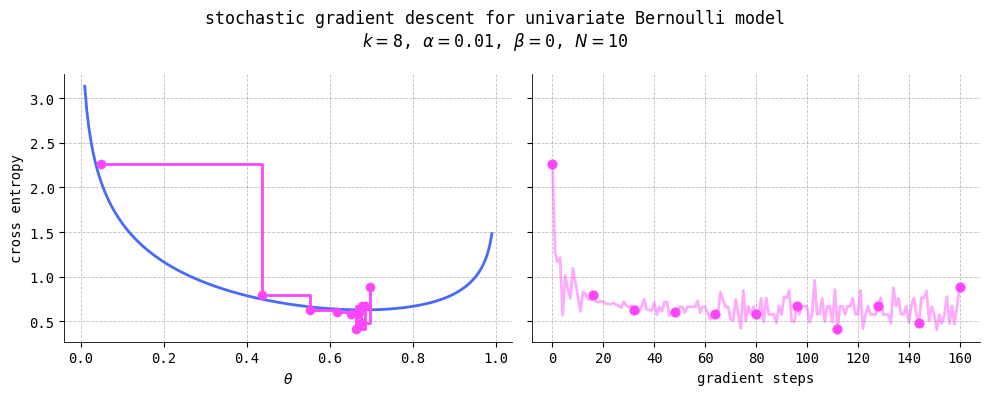

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
from math import sqrt

#import sys
#sys.path.append('/Users/johnmyers/code/math_stats_ml/src/math_stats_ml')
#from gd import GD, SGD, plot_sgd, plot_gd
from math_stats_ml.gd import GD, SGD, plot_sgd, plot_gd

#import matplotlib_inline.backend_inline
import matplotlib.colors as clr
plt.style.use('./aux-files/custom_style_light.mplstyle')
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
blue = '#486AFB'
magenta = '#FD46FC'

# generate data
torch.manual_seed(42)
m = 128
X = torch.bernoulli(torch.tensor([0.65] * m))

# define model surprisal function
def I_model(theta, x):
    return -x * torch.log(theta) - (1 - x) * torch.log(1 - theta)

def J(theta):
    return (-X * np.log(theta) - (1 - X) * np.log(1 - theta)).mean()

# initialize parameters
theta0 = torch.tensor([0.05])

# define SGD parameters
alpha = 0.01
k = 8
N = 10

# run SGD
sgd_output = SGD(g=I_model, init_parameters=theta0, X=X, lr=alpha, batch_size=k, num_epochs=N)

epoch_step_nums = sgd_output.epoch_step_nums
objectives = sgd_output.per_step_objectives[epoch_step_nums]
running_parameters = sgd_output.parameters['theta']
running_parameters = running_parameters[epoch_step_nums]
grid = np.linspace(start=0.01, stop=0.99, num=200)
y = np.apply_along_axis(J, axis=1, arr=grid.reshape(-1, 1))

_, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

axes[0].plot(grid, y)
axes[0].step(running_parameters, objectives, where='post', color=magenta)
axes[0].scatter(running_parameters, objectives, color=magenta, s=45, zorder=3)
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('cross entropy')

axes[1].plot(range(len(sgd_output.per_step_objectives)), sgd_output.per_step_objectives, color=magenta, alpha=0.45)
axes[1].scatter(epoch_step_nums, objectives, s=50, color=magenta, zorder=3)
axes[1].set_xlabel('gradient steps')

plt.suptitle(f'stochastic gradient descent for univariate Bernoulli model\n$k=${k}, $\\alpha =${alpha}, $\\beta=$0, $N = ${N}')
plt.tight_layout()

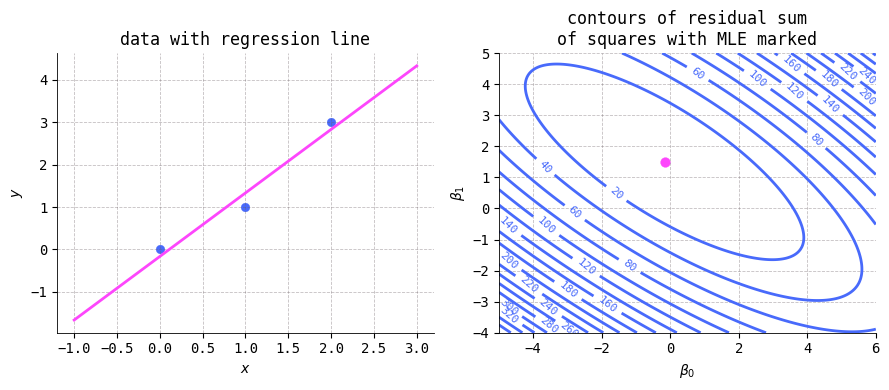

In [81]:
# toy data
X = torch.tensor([[1, 0], [1, 1], [1, 2]], dtype=torch.float32)
y = torch.tensor([0, 1, 3], dtype=torch.float32)

# closed form MLEs
beta0, beta1 = -1 / 6, 3 / 2

# define objective function, residual sum of squares
def J(theta):
    return torch.linalg.norm(y.reshape(-1, 1) - X @ theta, dim=0) ** 2

# define grid
x_grid = torch.linspace(-5, 6, steps=200)
y_grid = torch.linspace(-4, 5, steps=200)
x_grid, y_grid = torch.meshgrid(x_grid, y_grid)
grid = torch.column_stack((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1))).T
z = J(grid).reshape(x_grid.shape)

# plot
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

grid = np.linspace(-1, 3)
axes[0].scatter(X[:, 1], y, s=40)
axes[0].plot(grid, beta0 + beta1 * grid, color=magenta)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('data with regression line')

contour = axes[1].contour(x_grid, y_grid, z, levels=20, colors=blue, linestyles='solid')
plt.clabel(contour, fontsize=8)
axes[1].scatter([beta0], [beta1], s=50, color=magenta)
axes[1].set_xlabel('$\\beta_0$')
axes[1].set_ylabel('$\\beta_1$')
axes[1].set_title('contours of residual sum\nof squares with MLE marked')

plt.tight_layout()

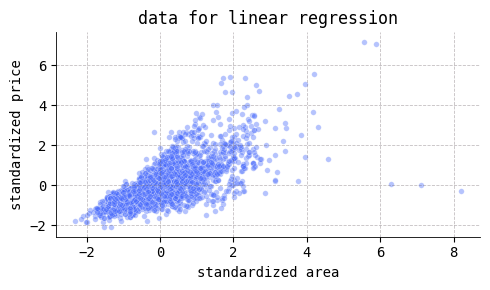

In [90]:
from sklearn.preprocessing import StandardScaler

# import data
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/data-3-1.csv'
df = pd.read_csv(url, usecols=['area', 'price'])

ss = StandardScaler()
data_std = ss.fit_transform(df.to_numpy())

sns.scatterplot(x=data_std[:, 0], y=data_std[:, 1], alpha=0.4)
plt.gcf().set_size_inches(w=5, h=3)
plt.xlabel('standardized area')
plt.ylabel('standardized price')
plt.title('data for linear regression')
plt.tight_layout()

X = torch.tensor(data_std[:, 0], dtype=torch.float32)
y = torch.tensor(data_std[:, 1], dtype=torch.float32)

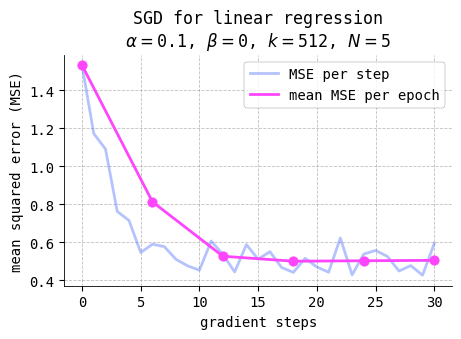

In [83]:
# define link function at Y
def mu_link(parameters, x):
    beta0 = parameters['beta0']
    beta = parameters['beta']
    return beta0 + beta * x

# define target function g for MSE
def g(parameters, x, y):
    mu = mu_link(parameters, x)
    return (y - mu) ** 2

# initialize parameters
beta0 = torch.tensor([1.])
beta = torch.tensor([1.])
theta0 = {'beta0': beta0, 'beta': beta}

# define SGD parameters
alpha = 0.1
N = 5
k = 512

# run SGD
sgd_output = SGD(g=g, init_parameters=theta0, X=X, y=y, lr=alpha, batch_size=k, num_epochs=N, random_state=42)

# plot SGD output
plot_sgd(sgd_output,
         ylabel='mean squared error (MSE)',
         plot_title_string='SGD for linear regression',
         h=3,
         per_step_label='MSE per step',
         per_epoch_label='mean MSE per epoch',
         per_epoch_color=magenta,
         legend=True,
         per_step_alpha=0.4)

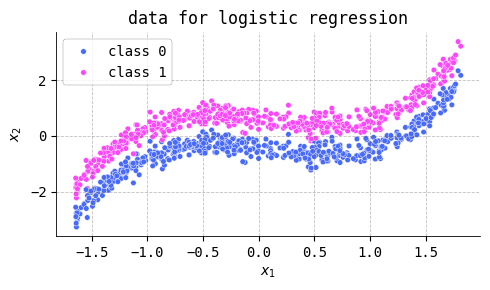

In [84]:
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch12-book-data-01.csv'
df = pd.read_csv(url)

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# convert the data to torch tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32)

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.title('data for logistic regression')
plt.tight_layout()

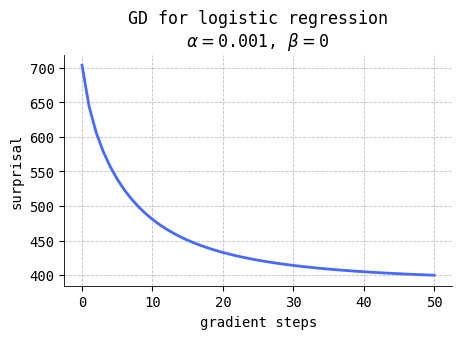

In [85]:
# define link function at Y
def phi_fn(parameters, x):
    beta0 = parameters['beta0']
    beta = parameters['beta']
    return torch.sigmoid(beta0 + x @ beta)

# define the data surprisal function
def I_data(parameters):
    phi = phi_fn(parameters, X)
    return torch.sum(-y * torch.log(phi) - (1 - y) * torch.log(1 - phi))

# initialize parameters
torch.manual_seed(42)
beta0 = torch.normal(mean=0, std=1e-1, size=(1,))
beta = torch.normal(mean=0, std=1e-1, size=(2,))
theta0 = {'beta0': beta0, 'beta': beta}

# define GD parameters
N = 50
alpha = 1e-3

# run GD
gd_output = GD(J=I_data, init_parameters=theta0, lr=alpha, num_steps=N)

# plot GD
plot_gd(gd_output, plot_title_string='GD for logistic regression', ylabel='surprisal', h=3)

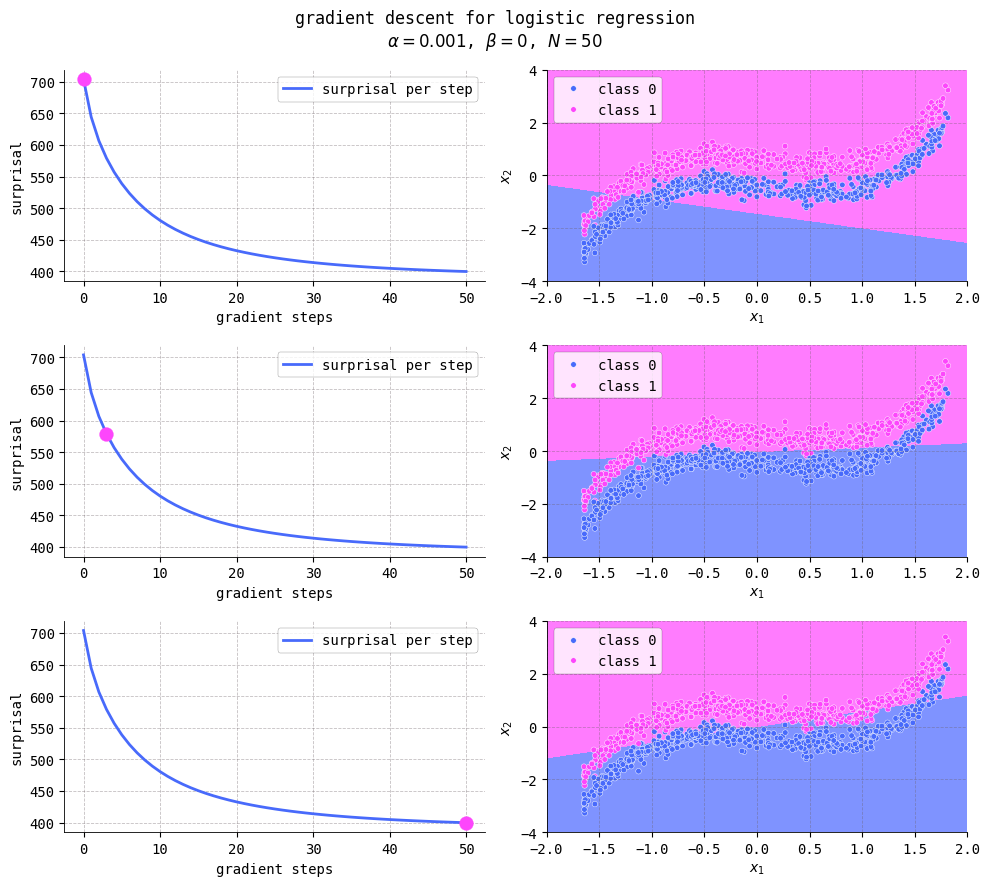

In [86]:
# define the predictor
def predictor(X, parameters):
    phi = phi_fn(parameters, X)
    return (phi >= 0.5).to(torch.int)

# define grid for contour plot
resolution = 1000
x1_grid = torch.linspace(-2, 2, resolution)
x2_grid = torch.linspace(-4, 4, resolution)
x1_grid, x2_grid = torch.meshgrid(x1_grid, x2_grid)
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

# define colormap for the contour plots
desat_blue = '#7F93FF'
desat_magenta = '#FF7CFE'
binary_cmap = clr.LinearSegmentedColormap.from_list(name='binary', colors=[desat_blue, desat_magenta], N=2)

epoch_list = [0, 3, N]
running_parameters = gd_output.parameters

_, axes = plt.subplots(ncols=2, nrows=len(epoch_list), figsize=(10, 9))

for i, epoch in enumerate(epoch_list):
    parameters = {key: value[epoch] for key, value in running_parameters.items()}
    
    # plot the objective function
    axes[i, 0].plot(gd_output.grad_steps, gd_output.per_step_objectives, label='surprisal per step')
    axes[i, 0].set_xlabel('gradient steps')
    axes[i, 0].set_ylabel('surprisal')
    axes[i, 0].scatter(epoch_list[i], gd_output.per_step_objectives[epoch], color=magenta, s=100, zorder=3)
    axes[i, 0].legend()

    # apply the fitted model to the grid
    z = predictor(grid, parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[i, 1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
    axes[i, 1].set_xlabel('$x_1$')
    axes[i, 1].set_ylabel('$x_2$')

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[i, 1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)
    
plt.suptitle(f'gradient descent for logistic regression\n$\\alpha={alpha}$, $\\beta=0$, $N={N}$')
plt.tight_layout()

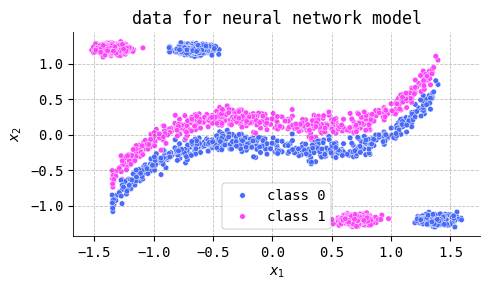

In [87]:
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch12-book-data-02.csv'
df = pd.read_csv(url)

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# convert the data to torch tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32)

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gcf().set_size_inches(w=5, h=3)
plt.title('data for neural network model')
plt.tight_layout()

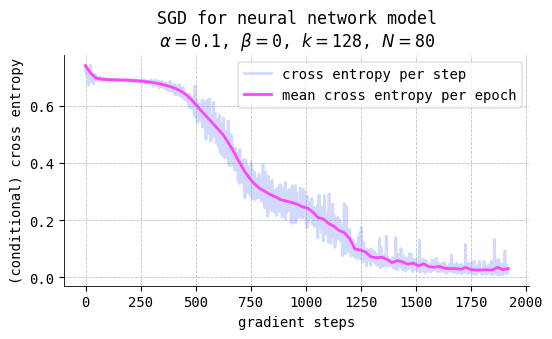

In [88]:
# define link function at Y
def phi_fn(parameters, x):
    W1 = parameters['weight_1']
    W2 = parameters['weight_2']
    W3 = parameters['weight_3']
    W4 = parameters['weight_4']
    b1 = parameters['bias_1']
    b2 = parameters['bias_2']
    b3 = parameters['bias_3']
    b4 = parameters['bias_4']
    z0 = x
    z1 = F.relu(z0 @ W1 + b1)
    z2 = F.relu(z1 @ W2 + b2)
    z3 = F.relu(z2 @ W3 + b3)
    phi = torch.sigmoid(z3 @ W4 + b4)
    return phi

# define the model surprisal function
def I_model(parameters, x, y):
    phi = phi_fn(parameters, x)
    return -y * torch.log(phi) - (1 - y) * torch.log(1 - phi)

# define the network architecture
k1 = 8 # width of first hidden layer
k2 = 8 # width of second hidden layer
k3 = 4 # width of third hidden layer
widths = [2, k1, k2, k3, 1]

# initialize parameters
torch.manual_seed(42)
theta0 = {}
for i in range(1, 5):
    weight = torch.empty(widths[i-1], widths[i])
    bias = torch.empty(widths[i])
    nn.init.uniform_(weight, a=-1/sqrt(widths[i-1]), b=1/sqrt(widths[i-1]))
    nn.init.uniform_(bias, a=-1/sqrt(widths[i-1]), b=1/sqrt(widths[i-1]))
    theta0 = theta0 | {'weight_' + str(i): weight.squeeze()}
    theta0 = theta0 | {'bias_' + str(i): bias}

# define SGD parameters
N = 80
k = 128
alpha = 0.1

# run SGD
sgd_output = SGD(g=I_model, init_parameters=theta0, X=X, y=y, lr=alpha, batch_size=k, num_epochs=N, random_state=42)

# plot SGD
plot_sgd(sgd_output,
         h=3,
         w=6,
         s=0,
         plot_title_string='SGD for neural network model',
         ylabel='(conditional) cross entropy',
         legend=True,
         per_step_label='cross entropy per step',
         per_epoch_label='mean cross entropy per epoch')

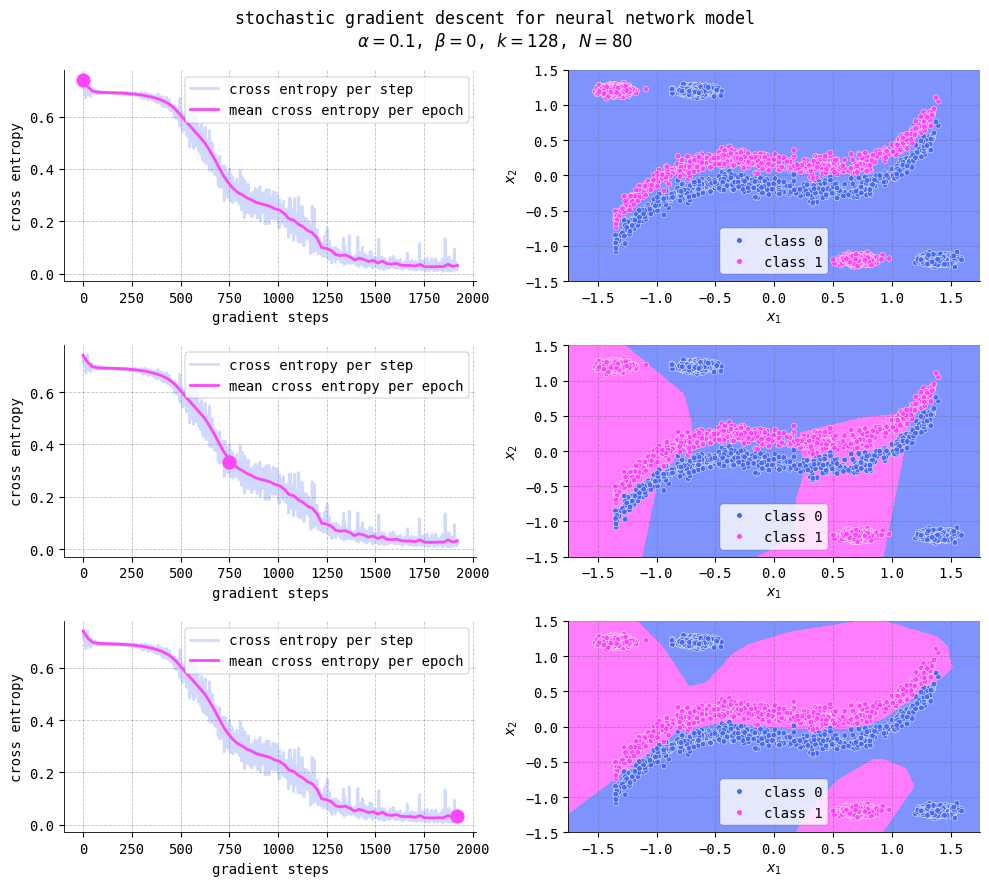

In [89]:
# define the predictor
def predictor(X, parameters):
    phi = phi_fn(parameters, X)
    return (phi >= 0.5).to(torch.int)

# get the grid for the contour plot
resolution = 1000
x1_grid = torch.linspace(-1.75, 1.75, resolution)
x2_grid = torch.linspace(-1.5, 1.5, resolution)
x1_grid, x2_grid = torch.meshgrid(x1_grid, x2_grid)
grid = torch.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))

epoch_list = [0, 750, len(sgd_output.per_step_objectives) - 1]
running_parameters = sgd_output.parameters

_, axes = plt.subplots(ncols=2, nrows=len(epoch_list), figsize=(10, 9))

for i, epoch in enumerate(epoch_list):
    parameters = {key: value[epoch] for key, value in running_parameters.items()}
    
    # plot the objective function
    axes[i, 0].plot(sgd_output.grad_steps, sgd_output.per_step_objectives, alpha=0.25, label='cross entropy per step')
    axes[i, 0].plot(sgd_output.epoch_step_nums, sgd_output.per_epoch_objectives, label='mean cross entropy per epoch')
    axes[i, 0].set_xlabel('gradient steps')
    axes[i, 0].set_ylabel('cross entropy')
    axes[i, 0].scatter(epoch_list[i], sgd_output.per_step_objectives[epoch], color=magenta, s=100, zorder=3)
    axes[i, 0].legend()

    # apply the fitted model to the grid
    z = predictor(grid, parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[i, 1].contourf(x1_grid, x2_grid, z, cmap=binary_cmap)
    axes[i, 1].set_xlabel('$x_1$')
    axes[i, 1].set_ylabel('$x_2$')

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[i, 1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)
    
plt.suptitle(f'stochastic gradient descent for neural network model\n$\\alpha={alpha}$, $\\beta=0$, $k={k}$, $N={N}$')
plt.tight_layout()